In [1]:
# %matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import requests
import re

import requests
from bs4 import BeautifulSoup, Comment
import time

import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

## SETUP:

In [22]:
url_master = "https://www.sports-reference.com/cbb/conferences/"
r_master = requests.get(url_master).content
soup_master = BeautifulSoup(r_master,'lxml')

cols = ['Conference', 'From', 'To', 'W', 'L', 'W-L' ,'SRS', 'SOS', 'AP', 'NCAA', 'FF', 'NC']
master_df = pd.DataFrame(columns = cols + ['url'])

tbls = soup_master.findAll('table', {'class': 'sortable stats_table'})
for t in tbls:
    for tr in t.find_all('tr')[1:]:
        tds = tr.find_all('td')
        
        new_df = pd.DataFrame([[elem.text.encode('utf-8') for elem in tds]], columns=cols)
        new_df['url'] = tds[0].find('a').get('href')
        master_df = master_df.append(new_df)
        
master_df.to_csv('conference_list.csv', index=False)

## MASTER SCRAPING:

In [52]:
master_df = pd.read_csv('conference_list.csv')
master_df.head()

,Conference,From,To,W,L,W-L,SRS,SOS,AP,NCAA,FF,NC,url
0,American Athletic Conference,2014,2017,801,626,0.561,6.49,4.13,7,12,1,1,/cbb/conferences/aac/
1,Atlantic Coast Conference,1954,2017,10799,6878,0.611,10.71,6.66,184,229,45,14,/cbb/conferences/acc/
2,America East Conference,1980,2017,4811,5396,0.471,-7.42,-5.43,0,38,0,0,/cbb/conferences/america-east/
3,Atlantic 10 Conference,1977,2017,7558,6564,0.535,3.45,2.80,34,109,1,0,/cbb/conferences/atlantic-10/
4,Atlantic Sun Conference,1979,2017,5325,5692,0.483,-7.91,-5.46,1,37,0,0,/cbb/conferences/atlantic-sun/


In [53]:
# ORIGINAL: start at 1980 (previously many teams played as independents)
#master_df = master_df[master_df['To']>=1980]

# V2: 1939-1979
master_df = master_df[master_df['To']>=1939]
master_df = master_df[master_df['From']<1980]
master_df = master_df[master_df['Conference']!="Independent"]
master_df.tail()

,Conference,From,To,W,L,W-L,SRS,SOS,AP,NCAA,FF,NC,url
49,Northern California Conference,1938,1939,106,90,0.541,NaN,NaN,0,0,0,0,/cbb/conferences/northern-ca/
50,Skyline Conference,1911,1962,4228,3627,0.538,-1.56,-0.56,10,23,3,1,/cbb/conferences/skyline/
51,Southwest Conference,1915,1996,7892,6982,0.531,0.46,0.92,21,78,12,0,/cbb/conferences/swc/
52,Western New York Little Three Conference,1947,1958,565,343,0.622,4.21,2.76,3,3,0,0,/cbb/conferences/wny3/
53,Yankee Conference,1938,1976,1918,1706,0.529,-11.88,-8.73,0,14,0,0,/cbb/conferences/yankee/


In [54]:
url_base = 'https://www.sports-reference.com/'
url_cap = '-schedule.html'
url_tourney_cap = '.html'
years = range(1939, 1980)

In [55]:
def date_parser(s):
    return s[5:-6].strip()

In [56]:
def date_parser_tourney(s):
    return s[5:].strip()

In [59]:
%%time

# MASTER ITERATION:

game_cols = ['Date', 'Away', 'Away_Pts', 'Home', 'Home_Pts', 'OT', 'Notes']
games_df = pd.DataFrame(columns=game_cols + ['Conference','Year'])
tourney_cols = ['Date','Away','Away_Pts','At','Home','Home_Pts','OT','Box']
        
for index, row in master_df.iterrows():
    conf_df = pd.DataFrame(columns=game_cols + ['Conference','Year'])
    
    for y in years:
        # if out of range, skip
        if (y < row[1]) or (y > row[2]):
            continue
        
        time.sleep(5)
        
        # **** GET LIST OF CONFERENCE GAMES ****
        
        new_df = pd.DataFrame(columns=game_cols)
        
        u = url_base + row[-1] + str(y) + url_cap
        u_tourney = url_base + row[-1] + str(y) + url_tourney_cap
        
        # get main table of games:
        r = requests.get(u).content
        soup = BeautifulSoup(r,'lxml')
        
        if 'Page Not Found' in soup.find('title').text:
            continue
        
        games_tbl = soup.find('table', {'id': 'schedule'})
        
        # iterate through every game on table:
        for tr in games_tbl.findAll('tr'):
            tds = tr.findAll(['th', 'td']) # first column = th tags
            
            temp_df = pd.DataFrame([[elem.text.encode('utf-8') for elem in tds]], columns=game_cols)
            new_df = new_df.append(temp_df)
            
        # remove duplicate header rows and top header row
        new_df = new_df.drop_duplicates()[1:]
        new_df['Conference'] = row[0]
        new_df['Year'] = y
        
        
        # **** GET LIST OF TOURNAMENT GAMES ****
        r_tourney = requests.get(u_tourney).content
        soup_tourney = BeautifulSoup(r_tourney, 'lxml')
        
        tourney_df = pd.DataFrame(columns=tourney_cols)
        comments = soup_tourney.findAll(text=lambda text:isinstance(text, Comment))

        for c in comments:
            comment_soup = BeautifulSoup(comments[15], 'lxml')
            tourney_tbl = comment_soup.find('table', {'id': 'conference-tournament'})
            if tourney_tbl is not None:
                break
    
        # iterate through every game on table:
        try: 
            trs = tourney_tbl.findAll('tr')
            for tr in trs:
                tds = tr.findAll(['th', 'td']) # first column = th tags
                tourney_temp = pd.DataFrame([[elem.text.encode('utf-8') for elem in tds]], columns=tourney_cols)
                tourney_df = tourney_df.append(tourney_temp)
        except AttributeError: 
            pass
            
        
        # **** MERGE AND DROP CONFERENCE TOURNAMENT GAMES ****
        
        new_df['Date_clean'] = new_df['Date'].apply(lambda x: date_parser(str(x)))
        
        tourney_df['Date_clean'] = tourney_df['Date'].apply(lambda x: date_parser_tourney(str(x)))
        tourney_df['Tourney']='Y'
        tourney_days = tourney_df[['Date_clean','Tourney']].drop_duplicates()
        
        new_df = new_df.merge(tourney_days, on='Date_clean', how='left')
        new_df = new_df[new_df['Tourney']!="Y"].drop(['Date_clean','Tourney'], axis=1)
        
        # ADD TO MASTER:
        
        conf_df = conf_df.append(new_df)
        
        
    games_df = games_df.append(conf_df)
    games_df.to_csv('conference_games_working.csv', index=False)
    pickle.dump(games_df, open('conference_games_working.p', 'wb'))

Wall time: 1h 21min 43s


In [100]:
tourney_df

,Date,Away,Away_Pts,At,Home,Home_Pts,OT,Box,Date_clean,Tourney
0,,,,,,,,,,Y
0,"Tue, Mar 7",North Carolina State,61,@,Clemson,75,,Box Score,Mar 7,Y
0,"Tue, Mar 7",Pittsburgh,61,@,Georgia Tech,59,,Box Score,Mar 7,Y
0,"Tue, Mar 7",Boston College,78,@,Wake Forest,92,,Box Score,Mar 7,Y
0,"Wed, Mar 8",Wake Forest,90,@,Virginia Tech,99,,Box Score,Mar 8,Y
0,"Wed, Mar 8",Clemson,72,@,Duke,79,,Box Score,Mar 8,Y
0,"Wed, Mar 8",Miami (FL),62,@,Syracuse,57,,Box Score,Mar 8,Y
0,"Wed, Mar 8",Pittsburgh,63,@,Virginia,75,,Box Score,Mar 8,Y
0,"Thu, Mar 9",Virginia,58,@,Notre Dame,71,,Box Score,Mar 9,Y
0,"Thu, Mar 9",Virginia Tech,68,@,Florida State,74,,Box Score,Mar 9,Y


## BASELINE ANALYSIS

In [7]:
# feed in cleaned data
master_df = pd.read_csv('conference_games.csv')
master_df.describe(include='all')

,Date,Away,Away_Pts,Home,Home_Pts,OT,Notes,Conference,Year
count,105575,105575,105575.000000,105575,105575.000000,3892,18,105575,105575.000000
unique,5539,368,NaN,368,NaN,5,6,48,NaN
top,"Sat, Feb 6, 2016",Georgia,NaN,Alabama,NaN,OT,Conf W Forfeited,Southeastern Conference,NaN
freq,153,592,NaN,593,NaN,3213,10,6461,NaN
mean,NaN,NaN,68.855657,NaN,72.669770,NaN,NaN,NaN,1993.931973
std,NaN,NaN,12.502554,NaN,13.173959,NaN,NaN,NaN,17.563367
min,NaN,NaN,10.000000,NaN,12.000000,NaN,NaN,NaN,1950.000000
25%,NaN,NaN,60.000000,NaN,64.000000,NaN,NaN,NaN,1983.000000
50%,NaN,NaN,68.000000,NaN,72.000000,NaN,NaN,NaN,1998.000000
75%,NaN,NaN,77.000000,NaN,81.000000,NaN,NaN,NaN,2008.000000


In [8]:
master_df['Home_Win'] = np.where( (master_df['Home_Pts'] > master_df['Away_Pts']), 100, 0)
master_df['Home_Margin'] = master_df['Home_Pts'] - master_df['Away_Pts']
master_df.describe()

,Away_Pts,Home_Pts,Year,Home_Win,Home_Margin
count,105575.000000,105575.000000,105575.000000,105575.000000,105575.000000
mean,68.855657,72.669770,1993.931973,62.205067,3.814113
std,12.502554,13.173959,17.563367,48.487716,13.186141
min,10.000000,12.000000,1950.000000,0.000000,-74.000000
25%,60.000000,64.000000,1983.000000,0.000000,-5.000000
50%,68.000000,72.000000,1998.000000,100.000000,4.000000
75%,77.000000,81.000000,2008.000000,100.000000,12.000000
max,155.000000,157.000000,2017.000000,100.000000,87.000000


In [9]:
master_sum = master_df.groupby(['Year'])['Home_Win','Home_Margin'].mean()
#master_sum.to_csv('home_court_total.csv')

In [13]:
def draw_graph(df, colors, label_bool): # dataframe of graphs to be drawn; list of colors
    
    fig, ax = plt.subplots(figsize=(9,5))
    plt.tick_params(axis='both', which='major', labelsize=14)

    #ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    
    #ax.set_xlim(-0.5,4.5)
    #ax.set_ylim(75,125)
    
    #x_labels = ['< 20', '20-25', '25-30', '30-35', '35 +', '']
    #plt.xticks(range(0, 5), x_labels, fontsize=14)
    
    ix = 0
    for i in df.columns:
        ax.plot(df[i], '-', color=colors[ix])
        if label_bool:
            ax.text(2017.5, df.loc[2017, i], i, ha='left', va='center', fontsize=14, color=colors[ix])
        ix = ix+1
    
    if label_bool==False:
        # custom labels
        ax.text(2017.5, df.loc[2017, df.columns[0]], df.columns[0], ha='left', va='center', fontsize=14, color=colors[0])
        ax.text(2017.5, df.loc[2017, df.columns[1]]+0.1, df.columns[1], ha='left', va='center', fontsize=14, color=colors[1])
        
    ax.set_title(title, fontsize=16)
    
    y_min = ax.get_ylim()[0]
    y_max = ax.get_ylim()[1]
    y_range = (y_max - y_min)
    ax.text(2025, y_min - 0.1*y_range, "Note: Normalized to overall 2017 scoring environment.", ha='right', va='center', fontsize=10, color="#aaaaaa")
    #ax.text(2025, y_min - 0.1*y_range, "Note: Normalized to overall 2017 scoring environment. Raw data via Sports-Reference.com; analysis by NYC Buckets", ha='right', va='center', fontsize=10, color="#aaaaaa")
    
    sns.despine()
    #return data
    

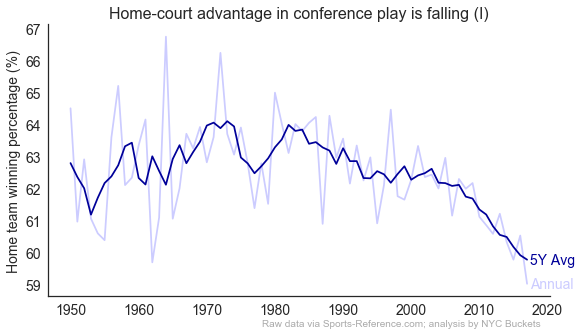

In [6]:
### WINNING PERCENTAGE:

# general parameters:
title = "Home-court advantage in conference play is falling (I)"
y_label = "Home team winning percentage (%)"
f_name = "NCAA_home_court_advantage_win_pct"
colors = ['#ccccff', '#000099']

output_pct = master_sum[['Home_Win']].rename(columns={'Home_Win': 'Annual'})
output_pct['5Y Avg'] = output_pct['Annual'].rolling(5, center=True, min_periods=1).mean()
#output_pct.tail()

sns.set_style('white')
draw_graph(output_pct, colors, True)
plt.savefig("imgs/"+f_name+".jpg", bbox_inches="tight")
plt.show()
plt.close()

In [16]:
# prepare index for scoring margin
score_index = master_df[['Year','Home_Pts','Away_Pts']].groupby('Year').mean()
score_index['PPG'] = (score_index['Home_Pts'] + score_index['Away_Pts'])/2
base = score_index.loc[2017, 'PPG']

score_index['Index'] = score_index['PPG'] / base

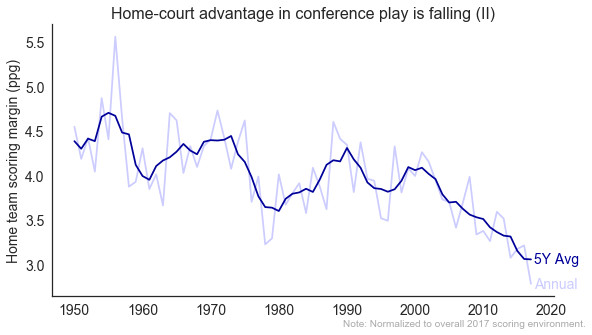

In [15]:
### SCORING MARGIN:

# general parameters:
title = "Home-court advantage in conference play is falling (II)"
y_label = "Home team scoring margin (ppg)"
f_name = "NCAA_home_court_advantage_margin_raw"
colors = ['#ccccff', '#000099']

## Normalize for ppg differences
#output_mgn = master_sum[['Home_Margin']].merge(score_index[['Index']], left_index=True, right_index=True)
#output_mgn['Home_Margin'] = output_mgn['Home_Margin'] / output_mgn['Index']
#output_mgn = output_mgn[['Home_Margin','Normalized']].rename(columns={'Home_Margin':'Actual'})
#output_mgn.tail()

output_mgn = master_sum[['Home_Margin']].rename(columns={'Home_Margin': 'Annual'})
output_mgn['5Y Avg'] = output_mgn['Annual'].rolling(5, center=True, min_periods=1).mean()

sns.set_style('white')
#draw_graph(output_mgn, colors, False)
draw_graph(output_mgn, colors, True)
plt.savefig("imgs/"+f_name+".jpg", bbox_inches="tight")
plt.show()
plt.close()

## HCA BY DISTANCE

In [24]:
from geopy.geocoders import Nominatim

school_df = pd.read_csv('school_list.csv', index_col='Rk')
school_df.head()

,School,"City, State"
Rk,,
1,Abilene Christian Wildcats,"Abilene, Texas"
2,Air Force Falcons,"USAF Academy, Colorado"
3,Akron Zips,"Akron, Ohio"
4,Alabama A&M Bulldogs,"Normal, Alabama"
5,Alabama Crimson Tide,"Tuscaloosa, Alabama"


In [26]:
%%time
geolocator = Nominatim()

for index, row in school_df[290:].iterrows(): # FIX INDEX
    geolocator = Nominatim()
    location = geolocator.geocode(row[1], timeout=10)
    
    try: 
        school_df.loc[index, 'Latitude'] = location.latitude
    except AttributeError:
        continue

    school_df.loc[index, 'Longitude'] = location.longitude
    time.sleep(1)
    
    if index%10==0:
        school_df.to_csv('school_locations.csv', index=False)

school_df.to_csv('school_locations.csv', index=False)

Wall time: 5min 27s


In [ ]:
# merge school name with sans-mascot name

In [33]:
r = requests.get('https://www.sports-reference.com/cbb/schools/').content
soup = BeautifulSoup(r,'lxml')

link_cols = ['href', 'text']
new_df = pd.DataFrame(columns=link_cols)

games_tbl = soup.find('table', {'id': 'schools'})

for a in games_tbl.findAll('a'):
    txt = a.text
    h = a.get('href')
    
    temp_df = pd.DataFrame([[h, txt]], columns=link_cols)
    new_df = new_df.append(temp_df)

            
# remove duplicate header rows and top header row
new_df = new_df.drop_duplicates()
new_df.head()

,href,text
0,/cbb/schools/abilene-christian/,Abilene Christian Wildcats
0,/cbb/schools/air-force/,Air Force Falcons
0,/cbb/schools/akron/,Akron Zips
0,/cbb/schools/alabama-am/,Alabama A&M Bulldogs
0,/cbb/schools/alabama/,Alabama Crimson Tide


In [35]:
new_df['School'] = new_df['text']
new_df['Title'] = new_df['href'].apply(lambda x: str(x).split("/")[-2].replace("-", " "))
#new_df.head()
new_df[['School','Title']].to_csv('name_cleaning.csv', index=False)

In [ ]:
######

In [53]:
# Pick up from file:
school_df = pd.read_csv('school_locations.csv')

helper_df = pd.read_csv('names_clean.csv')
helper_df.head()
school_df = school_df.merge(helper_df[['School','Title_Clean']], how='left', on='School').drop('School', axis=1).rename(columns={'Title_Clean':'School'})
school_df.head()

# feed in cleaned game data
master_df = pd.read_csv('conference_games.csv')
master_df['Home_Win'] = np.where( (master_df['Home_Pts'] > master_df['Away_Pts']), 100, 0)
master_df['Home_Margin'] = master_df['Home_Pts'] - master_df['Away_Pts']
master_df.describe()

,Away_Pts,Home_Pts,Year,Home_Win,Home_Margin
count,105575.000000,105575.000000,105575.000000,105575.000000,105575.000000
mean,68.855657,72.669770,1993.931973,62.205067,3.814113
std,12.502554,13.173959,17.563367,48.487716,13.186141
min,10.000000,12.000000,1950.000000,0.000000,-74.000000
25%,60.000000,64.000000,1983.000000,0.000000,-5.000000
50%,68.000000,72.000000,1998.000000,100.000000,4.000000
75%,77.000000,81.000000,2008.000000,100.000000,12.000000
max,155.000000,157.000000,2017.000000,100.000000,87.000000


In [54]:
dist_df = master_df.merge(school_df[['School','Latitude','Longitude']], how='left', left_on='Away', right_on='School', suffixes=('','_Away'))\
                    .merge(school_df[['School','Latitude','Longitude']], how='left', left_on='Home', right_on='School', suffixes=('','_Home'))

dist_df.head()

,Date,Away,Away_Pts,Home,Home_Pts,OT,Notes,Conference,Year,Home_Win,Home_Margin,School,Latitude,Longitude,School_Home,Latitude_Home,Longitude_Home
0,"Tue, Dec 31, 2013",Louisville,90,Central Florida,65,NaN,NaN,American Athletic Conference,2014,0,-25,Louisville,38.254238,-85.759407,Central Florida,28.542123,-81.379047
1,"Tue, Dec 31, 2013",Connecticut,71,Houston,75,NaN,NaN,American Athletic Conference,2014,100,4,Connecticut,41.808431,-72.249523,Houston,29.758938,-95.367697
2,"Tue, Dec 31, 2013",Memphis,88,South Florida,73,NaN,NaN,American Athletic Conference,2014,0,-15,Memphis,35.149022,-90.051629,South Florida,27.947759,-82.458444
3,"Wed, Jan 1, 2014",Southern Methodist,57,Cincinnati,65,NaN,NaN,American Athletic Conference,2014,100,8,Southern Methodist,32.776272,-96.796856,Cincinnati,39.101454,-84.512460
4,"Wed, Jan 1, 2014",Temple,66,Rutgers,71,NaN,NaN,American Athletic Conference,2014,100,5,Temple,39.952399,-75.163590,Rutgers,40.486217,-74.451817


In [55]:
import math

def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 3959 # miles

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [56]:
%%time
dist_df = dist_df[['Year','Home_Win','Home_Margin','Latitude','Longitude','Latitude_Home','Longitude_Home']]

for index, row in dist_df.iterrows():
    loc1 = (row[3], row[4])
    loc2 = (row[5], row[6])
    dist_df.loc[index, 'Distance'] = distance(loc1, loc2)
dist_df.head()


KeyboardInterrupt



In [39]:
bins = [-1, 200, 500, 9999]
lbls =['<200 mi','200-500','>500 mi']

dist_df['D'] = pd.cut(dist_df['Distance'], bins, labels=lbls)
dist_df.head()
dist_df.to_csv('raw_distance_data.csv', index=False)

,Year,Home_Win,Home_Margin,Latitude,Longitude,Latitude_Home,Longitude_Home,Distance,D
0,2014,0,-25,38.254238,-85.759407,28.542123,-81.379047,716.828787,>500 mi
1,2014,100,4,41.808431,-72.249523,29.758938,-95.367697,1532.554305,>500 mi
2,2014,0,-15,35.149022,-90.051629,27.947759,-82.458444,668.486033,>500 mi
3,2014,100,8,32.776272,-96.796856,39.101454,-84.512460,813.300953,>500 mi
4,2014,100,5,39.952399,-75.163590,40.486217,-74.451817,52.638549,<200 mi


In [58]:
# pick up distance data from file:
dist_df = pd.read_csv('raw_distance_data.csv', index_col=False)

In [59]:
metric = "Home_Margin" # toggle with Home_Win

In [60]:
score_index = master_df[['Year','Home_Pts','Away_Pts']].groupby('Year').mean()
score_index['PPG'] = (score_index['Home_Pts'] + score_index['Away_Pts'])/2
base = score_index.loc[2017, 'PPG']

score_index['Index'] = score_index['PPG'] / base

In [61]:
mid_df = dist_df.groupby(['Year','D'])[metric].mean().reset_index()

# Normalize for ppg differences
if metric == "Home_Margin":
    mid_df = mid_df.merge(score_index[['Index']], left_on='Year', right_index=True)
    mid_df['Home_Margin'] = mid_df['Home_Margin'] / mid_df['Index']


mid_df = mid_df.pivot('Year','D',metric)

graph_df = mid_df.rolling(5, center=True, min_periods=1).mean()
graph_df.head()

D,200-500,<200 mi,>500 mi
Year,,,
1950,5.822884,4.145970,8.557802
1951,5.433891,4.146187,7.645185
1952,5.431790,4.155139,7.870579
1953,4.892463,4.071802,7.417462
1954,4.888439,4.277805,7.467369


In [62]:
def draw_graph(df, colors, label_bool): # dataframe of graphs to be drawn; list of colors
    
    fig, ax = plt.subplots(figsize=(9,5))
    plt.tick_params(axis='both', which='major', labelsize=14)

    #ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    
    #ax.set_xlim(-0.5,4.5)
    #ax.set_ylim(75,125)
    
    #x_labels = ['< 20', '20-25', '25-30', '30-35', '35 +', '']
    #plt.xticks(range(0, 5), x_labels, fontsize=14)
    
    ix = 0
    for i in df.columns:
        ax.plot(df[i], '-', color=colors[ix])
        if label_bool:
            ax.text(2017.5, df.loc[2017, i], i, ha='left', va='center', fontsize=14, color=colors[ix])
        ix = ix+1
    
    if label_bool==False:
        # custom labels
        ax.text(2017.5, df.loc[2017, df.columns[0]]-0.1, df.columns[0], ha='left', va='center', fontsize=14, color=colors[0])
        ax.text(2017.5, df.loc[2017, df.columns[1]], df.columns[1], ha='left', va='center', fontsize=14, color=colors[1])
        ax.text(2017.5, df.loc[2017, df.columns[2]], df.columns[2], ha='left', va='center', fontsize=14, color=colors[2])
        
    ax.set_title(title, fontsize=16)
    
    y_min = ax.get_ylim()[0]
    y_max = ax.get_ylim()[1]
    y_range = (y_max - y_min)
    ax.text(2025, y_min - 0.1*y_range, "Note: 5-year rolling average normalized to 2017 avg ppg. Raw data via Sports-Reference.com; analysis by NYC Buckets", ha='right', va='center', fontsize=10, color="#aaaaaa")
    
    sns.despine()
    #return data
    

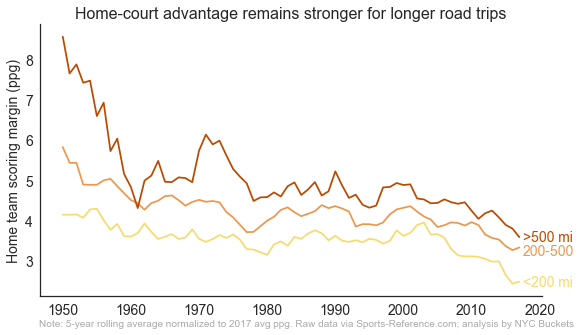

In [63]:
# general parameters:
title = "Home-court advantage remains stronger for longer road trips"
y_label = "Home team scoring margin (ppg)"
f_name = "NCAA_home_court_advantage_distance"
colors = ['#eb984e', '#f7db6f','#ba4a00']

sns.set_style('white')
draw_graph(graph_df, colors, False)
plt.savefig("imgs/"+f_name+".jpg", bbox_inches="tight")
plt.show()
plt.close()

## BY STRENGTH OF LEAGUE:

In [2]:
input_df = pd.read_csv('conference_list.csv')
input_df.head()

,Conference,From,To,W,L,W-L,SRS,SOS,AP,NCAA,FF,NC,url,Type
0,American Athletic Conference,2014,2017,801,626,0.561,6.49,4.13,7,12,1,1,/cbb/conferences/aac/,NaN
1,Atlantic Coast Conference,1954,2017,10799,6878,0.611,10.71,6.66,184,229,45,14,/cbb/conferences/acc/,Power
2,America East Conference,1980,2017,4811,5396,0.471,-7.42,-5.43,0,38,0,0,/cbb/conferences/america-east/,NaN
3,Atlantic 10 Conference,1977,2017,7558,6564,0.535,3.45,2.80,34,109,1,0,/cbb/conferences/atlantic-10/,NaN
4,Atlantic Sun Conference,1979,2017,5325,5692,0.483,-7.91,-5.46,1,37,0,0,/cbb/conferences/atlantic-sun/,NaN


In [3]:
conf_df = pd.read_csv('conference_games.csv')[['Conference','Year']].drop_duplicates().reset_index()
conf_df = conf_df[['Conference','Year']].merge(input_df[['Conference','Type']], how='left', on='Conference')
conf_df.head()

C:\Users\Whitaker Kevin\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Conference,Year,Type
0,American Athletic Conference,2014,NaN
1,American Athletic Conference,2015,NaN
2,American Athletic Conference,2016,NaN
3,American Athletic Conference,2017,NaN
4,Atlantic Coast Conference,1980,Power


In [4]:
%%time
url_base = 'https://www.sports-reference.com/'
cols = ['Rk', 'Season', 'Schls', 'W', 'L', 'W-L%', 'SRS', 'SOS', 'AP', 'NCAA', 'Regular Season Champ', 'Tournament Champ', 'POY']
conf_master = pd.DataFrame(columns=cols)
conf_master['Conference'] = ""

for index, row in input_df[['Conference','url','Type']].iterrows():
    
    time.sleep(5)
        
    u = url_base + row[1]
    
    # get main table of games:
    r = requests.get(u).content
    soup = BeautifulSoup(r,'lxml')
        
    if 'Page Not Found' in soup.find('title').text:
        continue
        
    conf_tbl = soup.find('table', {'class': 'sortable stats_table'})
    new_df = pd.DataFrame(columns=cols)
    
    # iterate through every game on table:
    for tr in conf_tbl.findAll('tr'):
        tds = tr.findAll(['th', 'td']) # first column = th tags
            
        temp_df = pd.DataFrame([[elem.text.encode('utf-8') for elem in tds]], columns=cols)
        new_df = new_df.append(temp_df)
        
    new_df['Conference'] = row[0]
    
    
    # remove duplicate header rows and top header row
    new_df = new_df.drop_duplicates()[1:]
    
    conf_master = conf_master.append(new_df)


conf_master['Year'] = conf_master['Season'].apply(lambda x: float(str(x)[:4]) + 1)
conf_master.to_csv('conference_details.csv')

KeyboardInterrupt: 

In [16]:
conf_master = pd.read_csv('conference_details_raw.csv')

conf_master = conf_master.sort_values(['Conference','Year']).apply(pd.to_numeric, errors='ignore').reset_index()
#conf_master = conf_master.groupby(['Conference','Year']).first()

temp_df = conf_master.groupby(['Conference'])['NCAA'].rolling(3, center=True, min_periods=1).mean().reset_index().rename(columns={'NCAA':'NCAA_3Y'})
conf_master = conf_master.merge(temp_df, how='left', left_index=True, right_index=True, suffixes=("","_temp"))

conf_master['Type'] = np.where((conf_master['NCAA_3Y'] >= 2), "Multi", "Other")
conf_master.to_csv('conference_details.csv')
#conf_master[45:90]

#### START ANALYSIS

In [23]:
# Pick up from file:
power_conf = pd.read_csv('conference_list.csv')[['Conference','Type']]
multi_conf = pd.read_csv('conference_details.csv')[['Conference','Year','NCAA_3Y','Type']]

# feed in cleaned data
games_df = pd.read_csv('conference_games.csv')
games_df['Home_Win'] = np.where( (games_df['Home_Pts'] > games_df['Away_Pts']), 100, 0)
games_df['Home_Margin'] = games_df['Home_Pts'] - games_df['Away_Pts']
#games_df.describe(include='all')

In [31]:
master_df = games_df.merge(power_conf, how='left', on='Conference')\
                .merge(multi_conf, how='left', on=['Conference','Year'], suffixes=('','_multi'))

master_df['Category'] = np.where( (pd.isnull(master_df['Type'])), master_df['Type_multi'], master_df['Type'])
master_df.describe(include='all')

#master_df[master_df['Date']=='Sat, Feb 11, 2017']

,Date,Away,Away_Pts,Home,Home_Pts,OT,Notes,Conference,Year,Home_Win,Home_Margin,Type,NCAA_3Y,Type_multi,Category
count,105575,105575,105575.000000,105575,105575.000000,3892,18,105575,105575.000000,105575.000000,105575.000000,28548,105575.000000,105575,105575
unique,5539,368,NaN,368,NaN,5,6,48,NaN,NaN,NaN,1,NaN,2,3
top,"Sat, Feb 6, 2016",Georgia,NaN,Alabama,NaN,OT,Conf W Forfeited,Southeastern Conference,NaN,NaN,NaN,Power,NaN,Other,Other
freq,153,592,NaN,593,NaN,3213,10,6461,NaN,NaN,NaN,28548,NaN,75752,66641
mean,NaN,NaN,68.855657,NaN,72.669770,NaN,NaN,NaN,1993.931973,62.205067,3.814113,NaN,1.945544,NaN,NaN
std,NaN,NaN,12.502554,NaN,13.173959,NaN,NaN,NaN,17.563367,48.487716,13.186141,NaN,1.689333,NaN,NaN
min,NaN,NaN,10.000000,NaN,12.000000,NaN,NaN,NaN,1950.000000,0.000000,-74.000000,NaN,0.000000,NaN,NaN
25%,NaN,NaN,60.000000,NaN,64.000000,NaN,NaN,NaN,1983.000000,0.000000,-5.000000,NaN,1.000000,NaN,NaN
50%,NaN,NaN,68.000000,NaN,72.000000,NaN,NaN,NaN,1998.000000,100.000000,4.000000,NaN,1.000000,NaN,NaN
75%,NaN,NaN,77.000000,NaN,81.000000,NaN,NaN,NaN,2008.000000,100.000000,12.000000,NaN,2.000000,NaN,NaN


In [33]:
metric = "Home_Margin" # toggle with Home_Win


# set up normalization
score_index = master_df[['Year','Home_Pts','Away_Pts']].groupby('Year').mean()
score_index['PPG'] = (score_index['Home_Pts'] + score_index['Away_Pts'])/2
base = score_index.loc[2017, 'PPG']

score_index['Index'] = score_index['PPG'] / base

In [47]:
mid_df = master_df.groupby(['Year','Category'])[metric].mean().reset_index()

# Normalize for ppg differences
if metric == "Home_Margin":
    mid_df = mid_df.merge(score_index[['Index']], left_on='Year', right_index=True)
    mid_df['Home_Margin'] = mid_df['Home_Margin'] / mid_df['Index']


mid_df = mid_df.pivot('Year','Category',metric)

graph_df = mid_df.rolling(5, center=True, min_periods=1).mean()
graph_df = graph_df[['Power','Multi','Other']].rename(columns={'Power':'Major confs','Multi':'Other multi-bids','Other':'Mid-majors'})
graph_df.tail()

Category,Major confs,Other multi-bids,Mid-majors
Year,,,
2013,4.153412,3.941051,3.330309
2014,4.156251,3.885997,3.247927
2015,4.049294,3.653336,2.996254
2016,3.961869,3.404030,2.867165
2017,3.892736,3.438401,2.867896


In [48]:
def draw_graph(df, colors, label_bool): # dataframe of graphs to be drawn; list of colors
    
    fig, ax = plt.subplots(figsize=(9,5))
    plt.tick_params(axis='both', which='major', labelsize=14)

    #ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    
    #ax.set_xlim(-0.5,4.5)
    #ax.set_ylim(75,125)
    
    #x_labels = ['< 20', '20-25', '25-30', '30-35', '35 +', '']
    #plt.xticks(range(0, 5), x_labels, fontsize=14)
    
    ix = 0
    for i in df.columns:
        ax.plot(df[i], '-', color=colors[ix])
        if label_bool:
            ax.text(2017.5, df.loc[2017, i], i, ha='left', va='center', fontsize=14, color=colors[ix])
        ix = ix+1
    
    if label_bool==False:
        # custom labels
        ax.text(2017.5, df.loc[2017, df.columns[0]]-0.1, df.columns[0], ha='left', va='center', fontsize=14, color=colors[0])
        ax.text(2017.5, df.loc[2017, df.columns[1]], df.columns[1], ha='left', va='center', fontsize=14, color=colors[1])
        ax.text(2017.5, df.loc[2017, df.columns[2]], df.columns[2], ha='left', va='center', fontsize=14, color=colors[2])
        
    ax.set_title(title, fontsize=16)
    
    y_min = ax.get_ylim()[0]
    y_max = ax.get_ylim()[1]
    y_range = (y_max - y_min)
    ax.text(2025, y_min - 0.1*y_range, "Note: 5-year rolling average normalized to 2017 avg ppg. Raw data via Sports-Reference.com; analysis by NYC Buckets", ha='right', va='center', fontsize=10, color="#aaaaaa")
    
    sns.despine()
    #return data
    

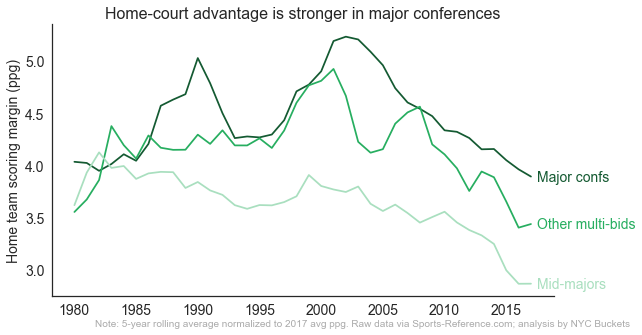

In [50]:
# general parameters:
title = "Home-court advantage is stronger in major conferences"
y_label = "Home team scoring margin (ppg)"
f_name = "NCAA_home_court_advantage_conference"
colors = ['#145a32', '#27ae60','#a9dfbf']

sns.set_style('white')
draw_graph(graph_df[30:], colors, True)
plt.savefig("imgs/"+f_name+".jpg", bbox_inches="tight")
plt.show()
plt.close()

## HCA BY ATTENDANCE

In [159]:
df_00 = pd.read_csv('attendance_2000.csv')[['Team','Avg']]
df_17 = pd.read_csv('attendance_2017.csv')[['Team','Avg']]

# feed in cleaned games data
games_df = pd.read_csv('conference_games.csv')
games_df['Home_Win'] = np.where( (games_df['Home_Pts'] > games_df['Away_Pts']), 100, 0)
games_df['Home_Margin'] = games_df['Home_Pts'] - games_df['Away_Pts']
#games_df.describe(include='all')

In [160]:
attendance_df = df_17.merge(df_00, how='left', on='Team', suffixes=('_17','_00'))
for i in ['Avg_00','Avg_17']:
    attendance_df[i] = attendance_df[i].apply(pd.to_numeric, errors='coerce')

attendance_df['Delta'] = attendance_df['Avg_17'] - attendance_df['Avg_00']
attendance_df['Delta_pct'] = attendance_df['Avg_17']/attendance_df['Avg_00'] - 1

attendance_df = attendance_df.sort_values('Delta', ascending=False).dropna().reset_index() # TOGGLE WITH 'DELTA'
attendance_df.loc[:25, 'Type'] = 'Top increases'
attendance_df.loc[292:, 'Type'] = 'Top decreases'
attendance_df['Type'].fillna('Others', inplace=True)
attendance_df

,index,Team,Avg_17,Avg_00,Delta,Delta_pct,Type
0,57,Creighton,17412,6494.0,10918.0,1.681244,Top increases
1,247,San Diego St.,12195,2618.0,9577.0,3.658136,Top increases
2,182,Nebraska,15427,7342.0,8085.0,1.101199,Top increases
3,324,Virginia,14245,7766.0,6479.0,0.834278,Top increases
4,332,West Virginia,11374,4899.0,6475.0,1.321698,Top increases
5,259,South Carolina,13395,9497.0,3898.0,0.410445,Top increases
6,32,Butler,8357,4594.0,3763.0,0.819112,Top increases
7,154,Marquette,13715,9971.0,3744.0,0.375489,Top increases
8,122,Iowa St.,14275,10543.0,3732.0,0.353979,Top increases
9,3,Alabama,11947,8257.0,3690.0,0.446894,Top increases


In [161]:
# BELOW IS INCORRECT -- NEED TO FILTER FOR *BOTH HOME AND AWAY* GAMES FOR RELEVANT TEAMS

#master_df = games_df.merge(attendance_df[['Team','Type']], left_on='Home', right_on='Team')
#master_df.to_csv('attendance_audit.csv', index=False)
#master_df.head()

In [162]:
metric = "Home_Win" # toggle with Home_Win


# set up normalization
score_index = master_df[['Year','Home_Pts','Away_Pts']].groupby('Year').mean()
score_index['PPG'] = (score_index['Home_Pts'] + score_index['Away_Pts'])/2
base = score_index.loc[2017, 'PPG']

score_index['Index'] = score_index['PPG'] / base

In [163]:
mid_df = master_df.groupby(['Year','Type'])[metric].mean().reset_index()

# Normalize for ppg differences
if metric == "Home_Margin":
    mid_df = mid_df.merge(score_index[['Index']], left_on='Year', right_index=True)
    mid_df['Home_Margin'] = mid_df['Home_Margin'] / mid_df['Index']


mid_df = mid_df.pivot('Year','Type',metric)

graph_df = mid_df.rolling(5, center=True, min_periods=1).mean()
graph_df = graph_df[['Top increases','Top decreases','Others']]
graph_df.tail()

Type,Top increases,Top decreases,Others
Year,,,
2013,62.836473,60.517590,60.997260
2014,62.108861,59.955412,60.823867
2015,63.033436,58.618868,60.313991
2016,63.474893,57.520160,59.867987
2017,64.120370,56.512141,59.688745


In [164]:
def draw_graph(df, colors, label_bool): # dataframe of graphs to be drawn; list of colors
    
    fig, ax = plt.subplots(figsize=(9,5))
    plt.tick_params(axis='both', which='major', labelsize=14)

    #ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    
    #ax.set_xlim(-0.5,4.5)
    #ax.set_ylim(75,125)
    
    #x_labels = ['< 20', '20-25', '25-30', '30-35', '35 +', '']
    #plt.xticks(range(0, 5), x_labels, fontsize=14)
    
    ix = 0
    for i in df.columns:
        ax.plot(df[i], '-', color=colors[ix])
        if label_bool:
            ax.text(2017.5, df.loc[2017, i], i, ha='left', va='center', fontsize=14, color=colors[ix])
        ix = ix+1
    
    if label_bool==False:
        # custom labels
        ax.text(2017.5, df.loc[2017, df.columns[0]]-0.1, df.columns[0], ha='left', va='center', fontsize=14, color=colors[0])
        ax.text(2017.5, df.loc[2017, df.columns[1]], df.columns[1], ha='left', va='center', fontsize=14, color=colors[1])
        ax.text(2017.5, df.loc[2017, df.columns[2]], df.columns[2], ha='left', va='center', fontsize=14, color=colors[2])
        
    ax.set_title(title, fontsize=16)
    
    y_min = ax.get_ylim()[0]
    y_max = ax.get_ylim()[1]
    y_range = (y_max - y_min)
    ax.text(2025, y_min - 0.1*y_range, "Note: 5-year rolling average normalized to 2017 avg ppg. Raw data via Sports-Reference.com; analysis by NYC Buckets", ha='right', va='center', fontsize=10, color="#aaaaaa")
    
    plt.axvline(2000, linestyle='dashed', lw=0.5, color='#cccccc')
    ax.text(2015, y_max, "2000-17 attendance chg:", ha='left', va='top', fontsize=14, weight='bold', color='#000000')
    
    sns.despine()
    #return data
    

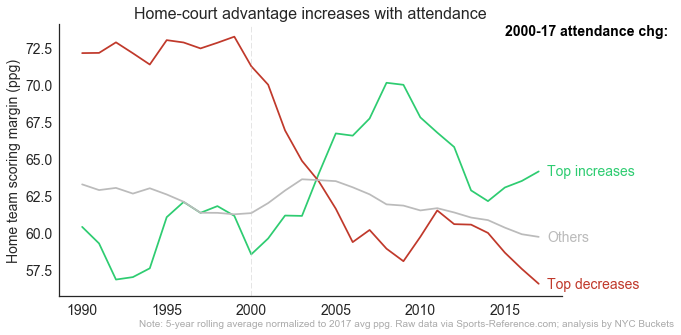

In [165]:
# general parameters:
title = "Home-court advantage increases with attendance"
y_label = "Home team scoring margin (ppg)"
f_name = "NCAA_home_court_advantage_attendance_2"
colors = ['#2ecc71', '#c0392b','#bbbbbb']

sns.set_style('white')
draw_graph(graph_df[40:], colors, True)
plt.savefig("imgs/"+f_name+".jpg", bbox_inches="tight")
plt.show()
plt.close()

### AVERAGE ATTENDANCE

In [215]:
attendance_df = pd.read_csv('attendance_total.csv')

# feed in cleaned games data
games_df = pd.read_csv('conference_games.csv')
games_df['Home_Win'] = np.where( (games_df['Home_Pts'] > games_df['Away_Pts']), 100, 0)
games_df['Home_Margin'] = games_df['Home_Pts'] - games_df['Away_Pts']
#games_df.describe(include='all')

In [216]:
master_sum = games_df.groupby(['Year'])['Home_Win','Home_Margin'].mean()
output_mgn = master_sum[['Home_Margin']].rename(columns={'Home_Margin': 'HCA'})

output_mgn = output_mgn.merge(attendance_df, how='left', left_index=True, right_on='Year').set_index('Year')

# only if rolling:
output_mgn['HCA (5Y avg)'] = output_mgn['HCA'].rolling(5, center=True, min_periods=1).mean()
output_mgn['Attendance (5Y avg)'] = output_mgn['Avg'].rolling(5, center=True, min_periods=1).mean()
output_mgn = output_mgn.drop(['HCA','Avg'], axis=1)

output_mgn.tail()

,HCA (5Y avg),Attendance (5Y avg)
Year,,
2013,3.321471,4902.200000
2014,3.311776,4846.000000
2015,3.150208,4773.800000
2016,3.059579,4737.000000
2017,3.055035,4710.333333


In [217]:
def draw_graph(df, colors, label_bool): # dataframe of graphs to be drawn; list of colors
    
    fig, ax = plt.subplots(figsize=(9,5))
    plt.tick_params(axis='both', which='major', labelsize=14)
    
    ax2 = ax.twinx()
    #ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel(y_label, fontsize=14, color=colors[0])
    ax2.set_ylabel(y_label_2, fontsize=14, color=colors[1])
    
    #ax.set_xlim(-0.5,4.5)
    #ax.set_ylim(75,125)
    
    #x_labels = ['< 20', '20-25', '25-30', '30-35', '35 +', '']
    #plt.xticks(range(0, 5), x_labels, fontsize=14)
    
    ax.plot(df[df.columns[0]], '-', color=colors[0])
    ax2.plot(df[df.columns[1]], '-', color=colors[1])
    
    ax2.yaxis.set_label_position("right")
    
    if label_bool==False:
        # custom labels
        ax.text(2017.5, df.loc[2017, df.columns[0]], df.columns[0], ha='left', va='center', fontsize=14, color=colors[0])
        ax.text(2017.5, df.loc[2017, df.columns[1]]+0.1, df.columns[1], ha='left', va='center', fontsize=14, color=colors[1])
        
    ax.set_title(title, fontsize=16)
    
    y_min = ax.get_ylim()[0]
    y_max = ax.get_ylim()[1]
    y_range = (y_max - y_min)
    ax.text(2020, y_min - 0.1*y_range, "Note: Normalized to overall 2017 scoring environment. Raw data via Sports-Reference.com and NCAA; analysis by NYC Buckets", ha='right', va='center', fontsize=10, color="#aaaaaa")
    
    sns.despine(ax=ax, right=True, left=False) 
    sns.despine(ax=ax2, left=True, right=False) 
    #return data
    

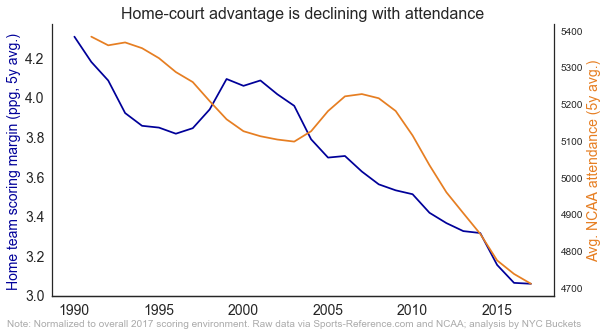

In [219]:
### WINNING PERCENTAGE:

# general parameters:
title = "Home-court advantage is declining with attendance"
y_label = "Home team scoring margin (ppg, 5y avg.)"
y_label_2 = "Avg. NCAA attendance (5y avg.)"
f_name = "NCAA_home_court_advantage_attendance"
colors = ['#000099','#e67e22']

sns.set_style('white')
draw_graph(output_mgn[40:], colors, True)
plt.savefig("imgs/"+f_name+".jpg", bbox_inches="tight")
plt.show()
plt.close()